# import python packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import seaborn as sns

# list parquet files

In [2]:
parquet_files = []

for file in os.listdir('../Output_SWMM_directory/'):
    if file.endswith('.parquet'):
        parquet_files.append(file)

parquet_files = pd.DataFrame(parquet_files, columns=['parquet_filename'])
parquet_files.sort_values(by='parquet_filename', inplace=True, ignore_index=True)
parquet_files

,parquet_filename
0,frequent______freq05_63_2_percentage__010__01....
1,frequent______freq05_63_2_percentage__010__02....
2,frequent______freq05_63_2_percentage__010__03....
3,frequent______freq05_63_2_percentage__010__04....
4,frequent______freq05_63_2_percentage__010__05....
...,...
805,rare__________freq13_1_percentage_____120__06....
806,rare__________freq13_1_percentage_____120__07....
807,rare__________freq13_1_percentage_____120__08....
808,rare__________freq13_1_percentage_____120__09....


# read parquet files

In [3]:
hydrograph_list = []

for index_1 in parquet_files.index:
    a1 = parquet_files.parquet_filename[index_1]
    a2 = pd.read_parquet('../Output_SWMM_directory/' + a1)
    a3 = pd.DataFrame({'frequency':[a1.split('__',1)[0]], 
                       'freq_AEP':[a1[14:].split('__',1)[0]], 
                       'duration':[int(a1[:-8][-7:-4])], 
                       'pattern':[int(a1[:-8][-2:])], 
                       'hydrograph':[a2]})
    hydrograph_list.append(a3)

hydrograph_list = pd.concat(hydrograph_list, ignore_index=True)
hydrograph_list

,frequency,freq_AEP,duration,pattern,hydrograph
0,frequent,freq05_63_2_percentage,10,1,timestamp flow 0 2023-01-...
1,frequent,freq05_63_2_percentage,10,2,timestamp flow 0 2023-01-...
2,frequent,freq05_63_2_percentage,10,3,timestamp flow 0 2023-01-...
3,frequent,freq05_63_2_percentage,10,4,timestamp flow 0 2023-01-...
4,frequent,freq05_63_2_percentage,10,5,timestamp flow 0 2023-01-...
...,...,...,...,...,...
805,rare,freq13_1_percentage,120,6,timestamp flow 0 2023-01-...
806,rare,freq13_1_percentage,120,7,timestamp flow 0 2023-01-...
807,rare,freq13_1_percentage,120,8,timestamp flow 0 2023-01...
808,rare,freq13_1_percentage,120,9,timestamp flow 0 2023-01-...


# get peak flow for each hydrograph

In [19]:
max_flow_list = []

for index_2 in hydrograph_list.index:
    b1 = hydrograph_list.hydrograph[index_2].flow.max()
    max_flow_list.append(b1)

max_flow_list = pd.DataFrame({'max_flow':max_flow_list})
max_flow_list = pd.concat([hydrograph_list.iloc[:,:4], max_flow_list], axis=1)
max_flow_list.to_csv('../GSPSWMMH_max_flows.csv', index=False)
max_flow_list

,frequency,freq_AEP,duration,pattern,max_flow
0,frequent,freq05_63_2_percentage,10,1,9.516278
1,frequent,freq05_63_2_percentage,10,2,9.680575
2,frequent,freq05_63_2_percentage,10,3,9.439044
3,frequent,freq05_63_2_percentage,10,4,9.696758
4,frequent,freq05_63_2_percentage,10,5,9.605475
...,...,...,...,...,...
805,rare,freq13_1_percentage,120,6,16.909500
806,rare,freq13_1_percentage,120,7,10.838783
807,rare,freq13_1_percentage,120,8,16.136631
808,rare,freq13_1_percentage,120,9,13.611984


# statistics

In [5]:
boundary_limits = pd.DataFrame(max_flow_list.groupby(by=max_flow_list.columns[:3].to_list()).max_flow.quantile(q=[0.05, 0.95])).unstack(level=-1)
boundary_limits.columns = [[ind[0] for ind in boundary_limits.columns], ['{}%'.format(int(ind[1] * 100)) for ind in boundary_limits.columns]]
boundary_limits

max_flow           
                                                  5%        95%
frequency freq_AEP               duration                      
frequent  freq05_63_2_percentage 10         9.473799  10.081019
                                 15        10.314386  10.955660
                                 20        10.101339  12.344045
                                 25         9.020845  11.644655
                                 30         9.013189  11.925705
...                                              ...        ...
rare      freq13_1_percentage    30        17.795577  20.186714
                                 45        16.466559  19.122830
                                 60        15.091767  19.810897
                                 90        12.357710  19.304920
                                 120       11.504265  19.149902

[81 rows x 2 columns]

In [16]:
statistics = max_flow_list.groupby(by=max_flow_list.columns[:3].to_list()).agg({'max_flow':['describe']})
statistics.columns = [[ind[0] for ind in statistics.columns], [ind[2] for ind in statistics.columns]]
statistics = pd.concat([statistics, boundary_limits], axis=1)
statistics = statistics[statistics.columns[[0, 1, 2, 3, 8, 4, 5, 6, 9, 7]]]
statistics.to_csv('../GSPSWMMH_statistics.csv')
statistics

max_flow                       \
                                             count       mean       std   
frequency freq_AEP               duration                                 
frequent  freq05_63_2_percentage 10           10.0   9.755178  0.217042   
                                 15           10.0  10.665796  0.239318   
                                 20           10.0  10.970691  0.861334   
                                 25           10.0  10.596148  1.139221   
                                 30           10.0  10.418170  1.178691   
...                                            ...        ...       ...   
rare      freq13_1_percentage    30           10.0  19.241915  0.913809   
                                 45           10.0  18.066102  1.037247   
                                 60           10.0  17.247070  1.767894   
                                 90           10.0  15.758506  2.570159   
                                 120          10.0  15.655876  2.717379   

                                                                            \
                                                 min         5%        25%   
frequency freq_AEP               duration                                    
frequent  freq05_63_2_percentage 10         9.439044   9.473799   9.624250   
                                 15        10.196048  10.314386  10.531219   
                                 20        10.073880  10.101339  10.237548   
                                 25         8.828242   9.020845   9.519944   
                                 30         8.866056   9.013189   9.449410   
...                                              ...        ...        ...   
rare      freq13_1_percentage    30        17.716975  17.795577  18.824029   
                                 45        16.005884  16.466559  17.421427   
                                 60        14.815290  15.091767  15.914392   
                                 90        12.123890  12.357710  14.224767   
                                 120       10.838783  11.504265  14.038894   

                                                                            \
                                                 50%        75%        95%   
frequency freq_AEP               duration                                    
frequent  freq05_63_2_percentage 10         9.723659   9.861020  10.081019   
                                 15        10.683780  10.851187  10.955660   
                                 20        10.932074  11.347149  12.344045   
                                 25        11.214701  11.524728  11.644655   
                                 30        10.190548  11.521269  11.925705   
...                                              ...        ...        ...   
rare      freq13_1_percentage    30        19.450429  19.954285  20.186714   
                                 45        18.248685  18.937259  19.122830   
                                 60        17.032452  18.274762  19.810897   
                                 90        15.834780  17.158833  19.304920   
                                 120       16.268597  16.879594  19.149902   

                                                      
                                                 max  
frequency freq_AEP               duration             
frequent  freq05_63_2_percentage 10        10.150133  
                                 15        10.970576  
                                 20        12.663137  
                                 25        11.709550  
                                 30        12.165036  
...                                              ...  
rare      freq13_1_percentage    30        20.355693  
                                 45        19.172413  
                                 60        20.727829  
                                 90        20.715052  
                                 120       19.445270  

[81 rows x 10 columns]

In [14]:
design_flows = statistics[statistics.columns[[1, 4, 6, 8]]]
design_flows.reset_index(inplace=True)
design_flows.columns = [ind[0] if ind[1] == '' else ind[1] for ind in design_flows.columns]
temp_var = list(design_flows.groupby(by=list(design_flows.columns[:2])))
design_flows = pd.concat(list(val[1].loc[val[1][val[1]['50%'] == val[1]['50%'].max()].index] 
                              for ind, val in enumerate(temp_var)), ignore_index=True)
design_flows = pd.concat([design_flows, pd.DataFrame({'AEP':[63.21, 50, 39.35, 20, 18.13, 10, 5, 2, 1]})], axis=1)
design_flows = design_flows[design_flows.columns[[0, 1, 2, 7, 3, 4, 5, 6]]]
design_flows.to_csv('../GSPSWMMH_design_flows.csv', index=False)
design_flows

,frequency,freq_AEP,duration,AEP,mean,5%,50%,95%
0,frequent,freq05_63_2_percentage,25,63.21,10.596148,9.020845,11.214701,11.644655
1,frequent,freq06_50_percentage,25,50.00,11.832939,10.164310,12.447470,12.933723
2,frequent,freq07_0_5_EY,25,39.35,13.085976,11.388534,13.672382,14.228379
3,frequent,freq08_20_percentage,20,20.00,15.557702,14.410984,15.665290,16.719961
4,frequent,freq09_0_2_EY,15,18.13,15.853758,14.990149,15.980652,16.342449
5,intermediate,freq10_10_percentage,15,10.00,17.178270,16.463530,17.329189,17.722844
6,intermediate,freq11_5_percentage,15,5.00,18.282410,17.856616,18.059403,18.885190
7,rare,freq12_2_percentage,15,2.00,19.411474,18.760601,19.287573,20.011110
8,rare,freq13_1_percentage,15,1.00,20.280973,19.398207,20.398690,20.962577


# plot

In [8]:
titles = max_flow_list[['frequency', 'freq_AEP']].drop_duplicates(ignore_index=True)
titles

,frequency,freq_AEP
0,frequent,freq05_63_2_percentage
1,frequent,freq06_50_percentage
2,frequent,freq07_0_5_EY
3,frequent,freq08_20_percentage
4,frequent,freq09_0_2_EY
5,intermediate,freq10_10_percentage
6,intermediate,freq11_5_percentage
7,rare,freq12_2_percentage
8,rare,freq13_1_percentage


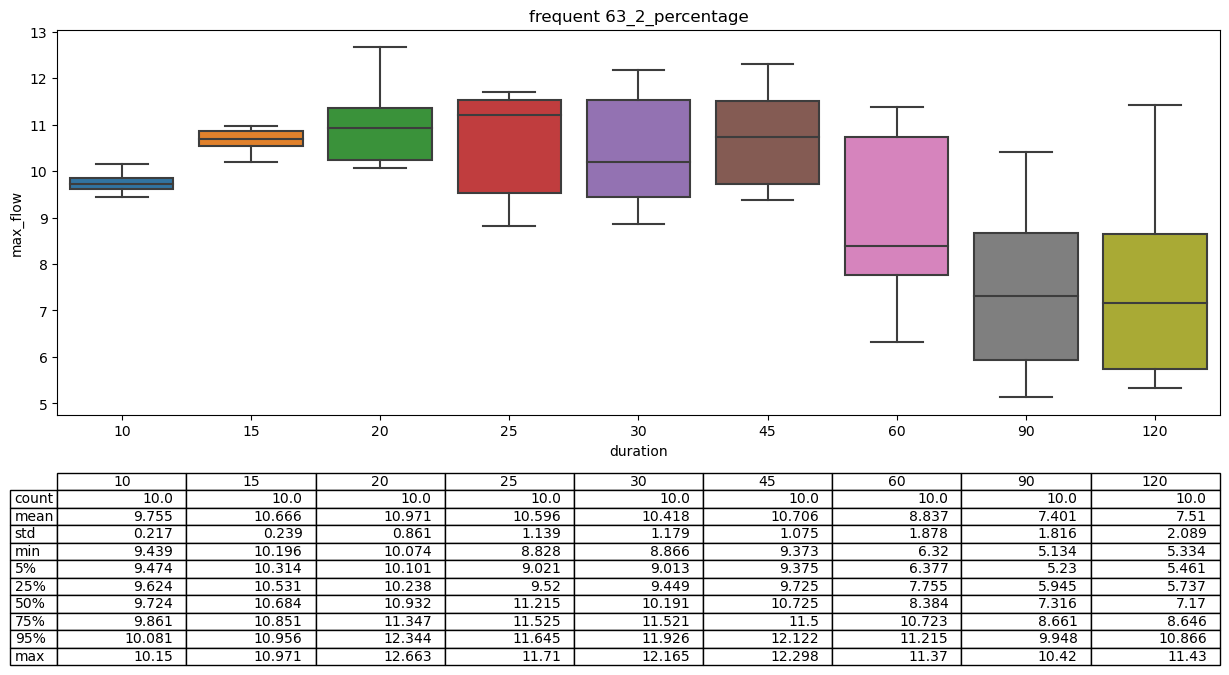

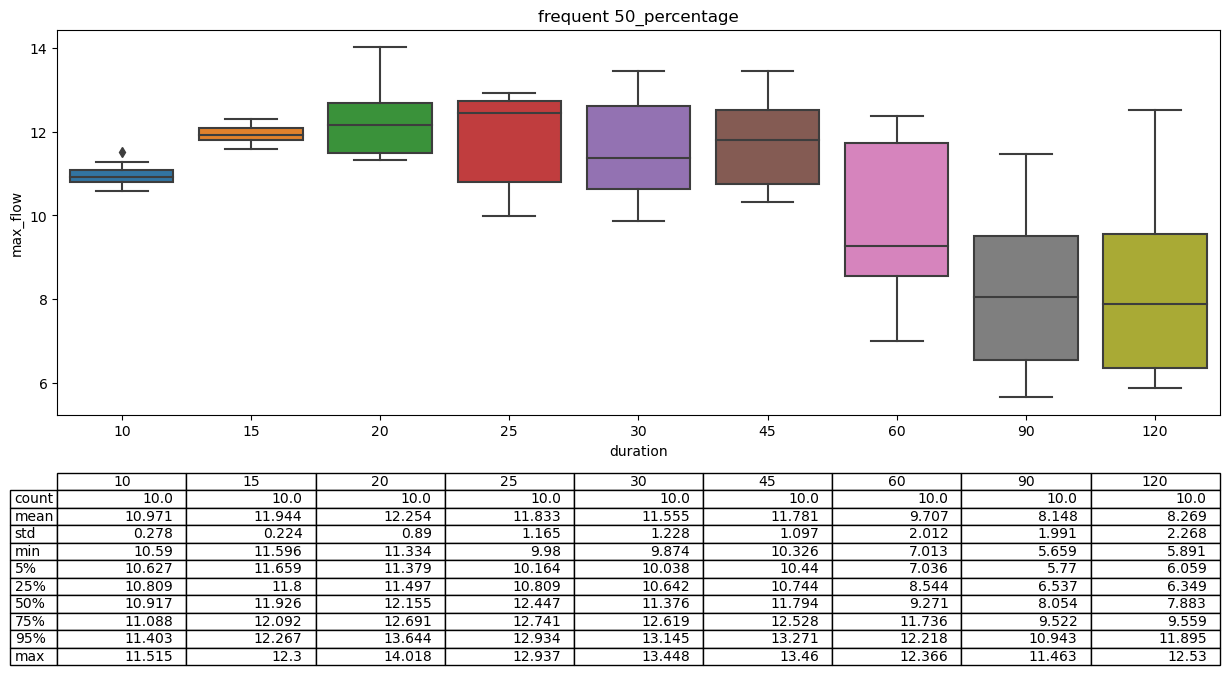

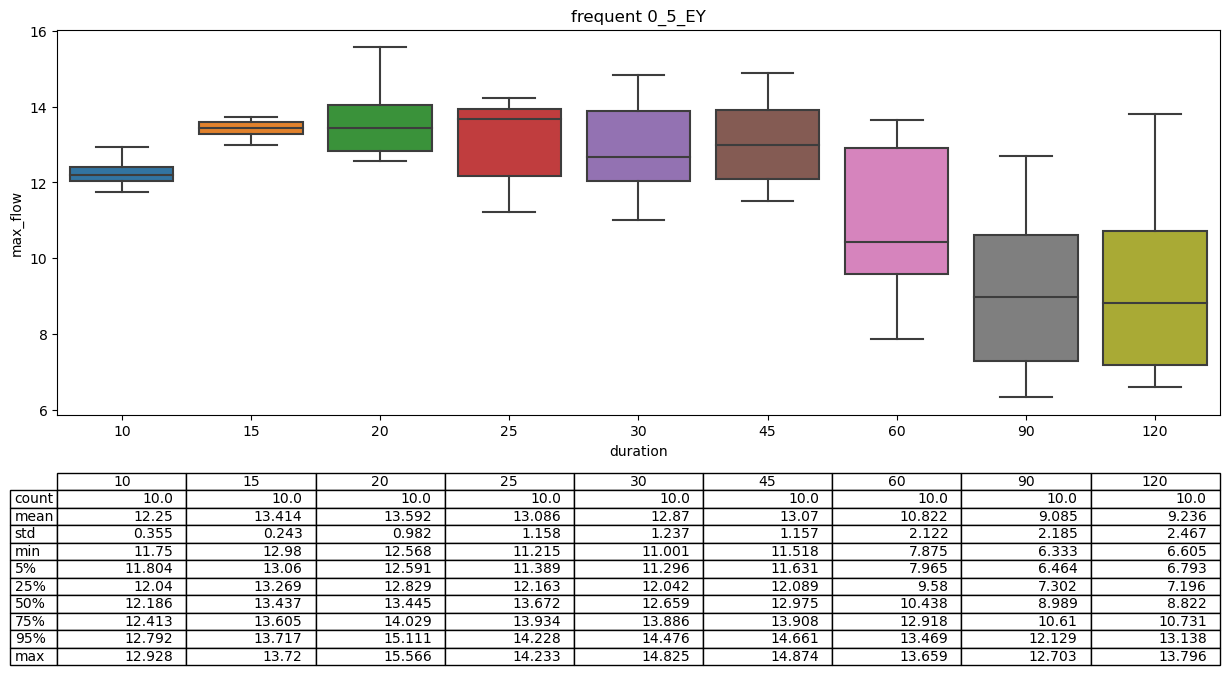

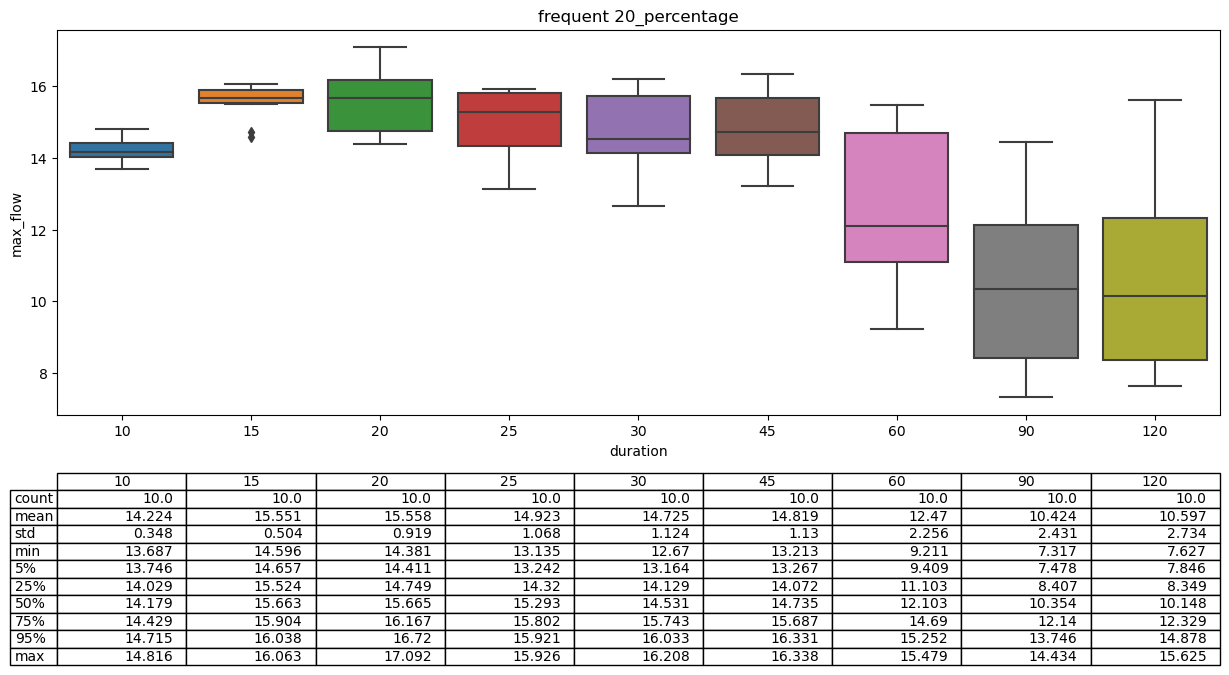

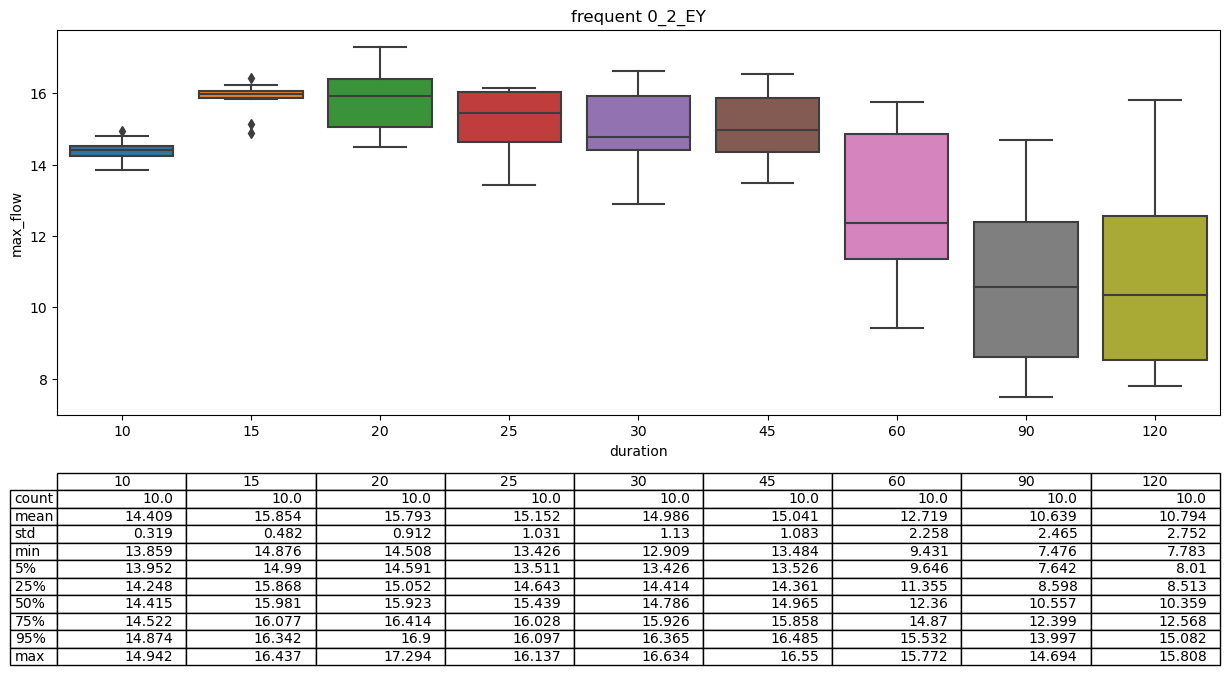

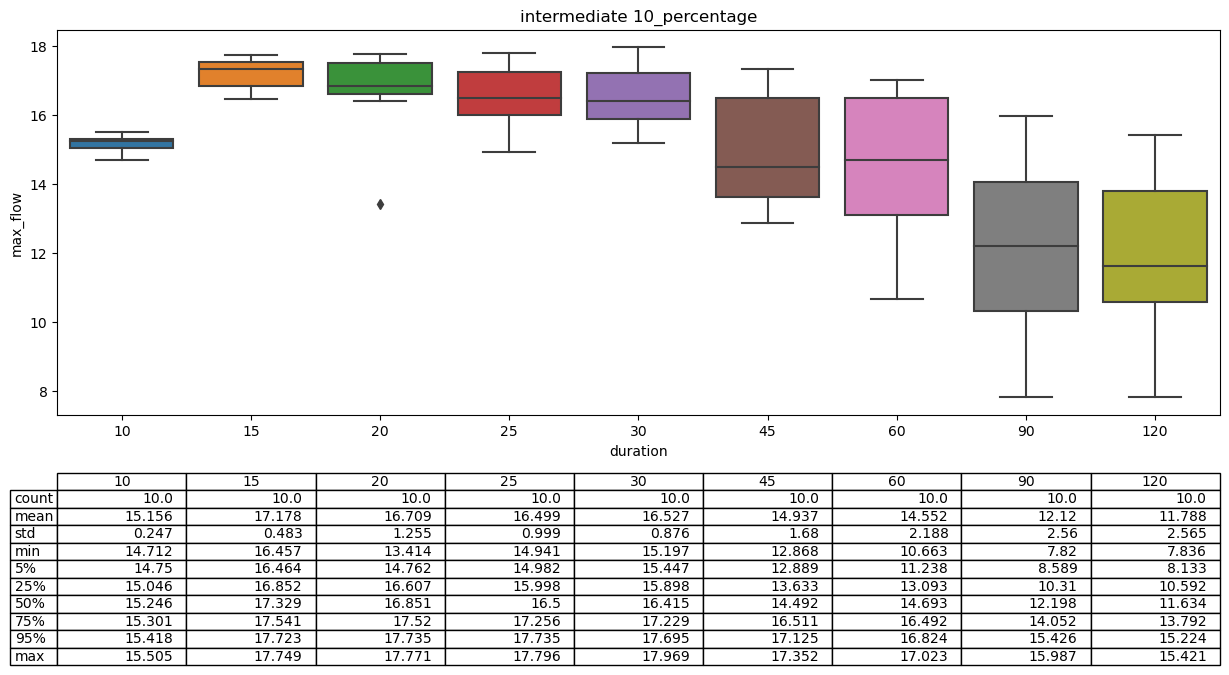

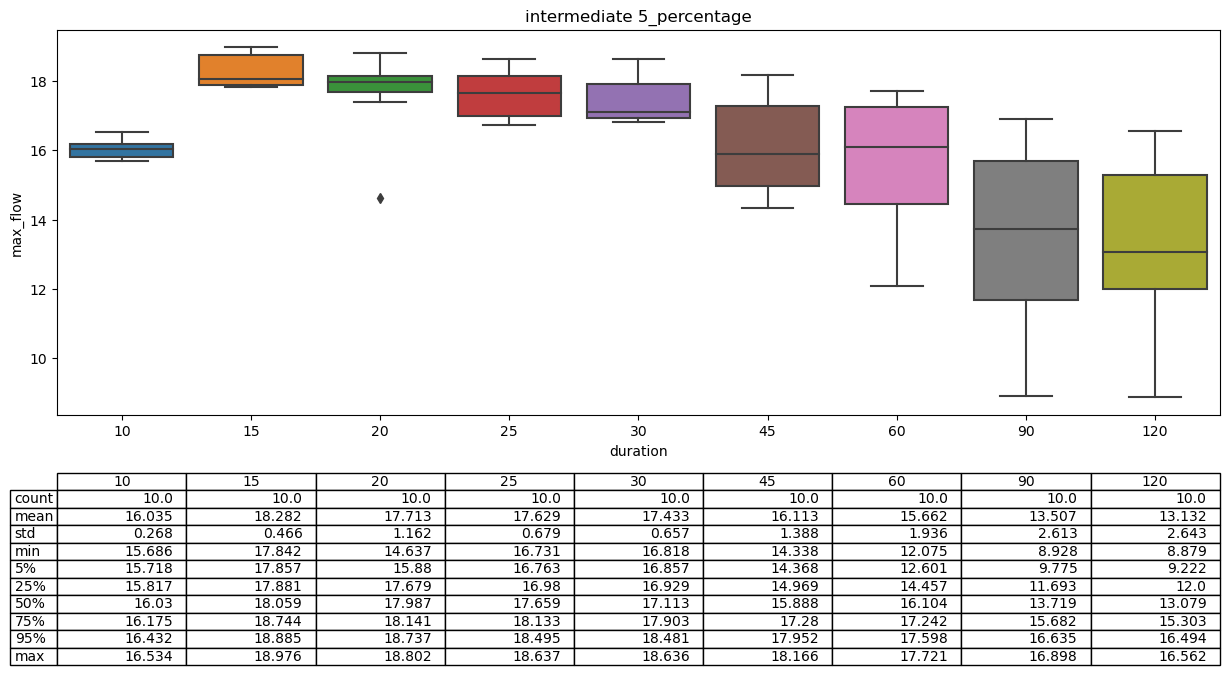

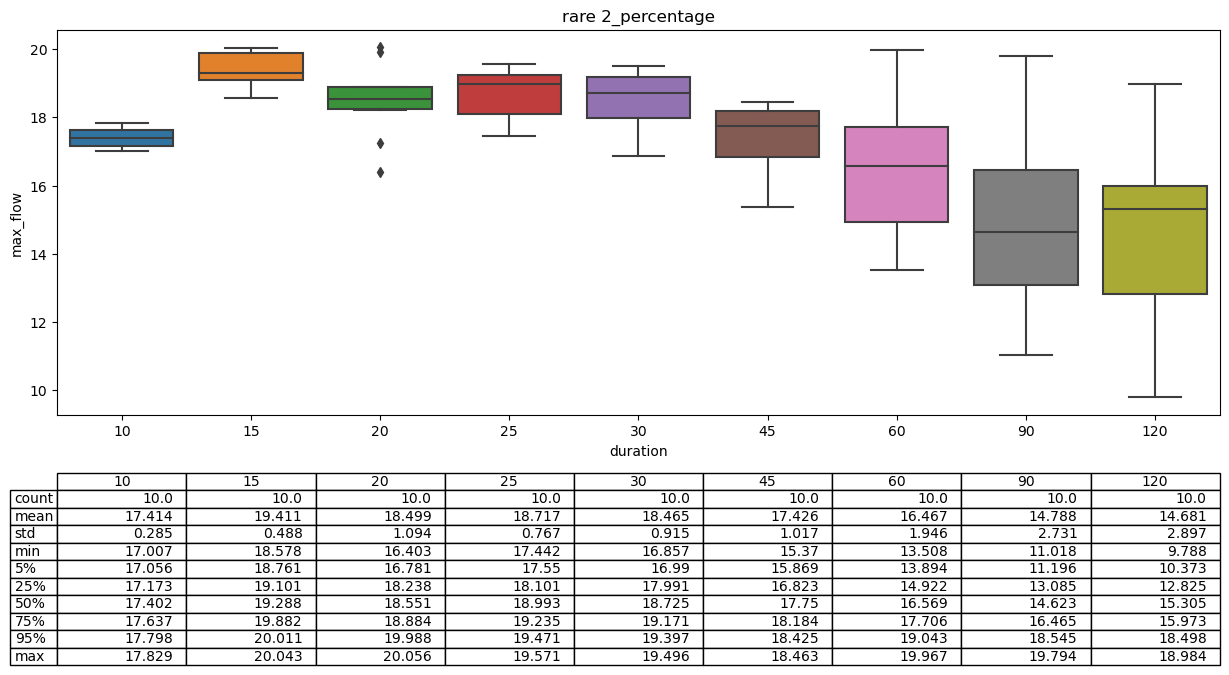

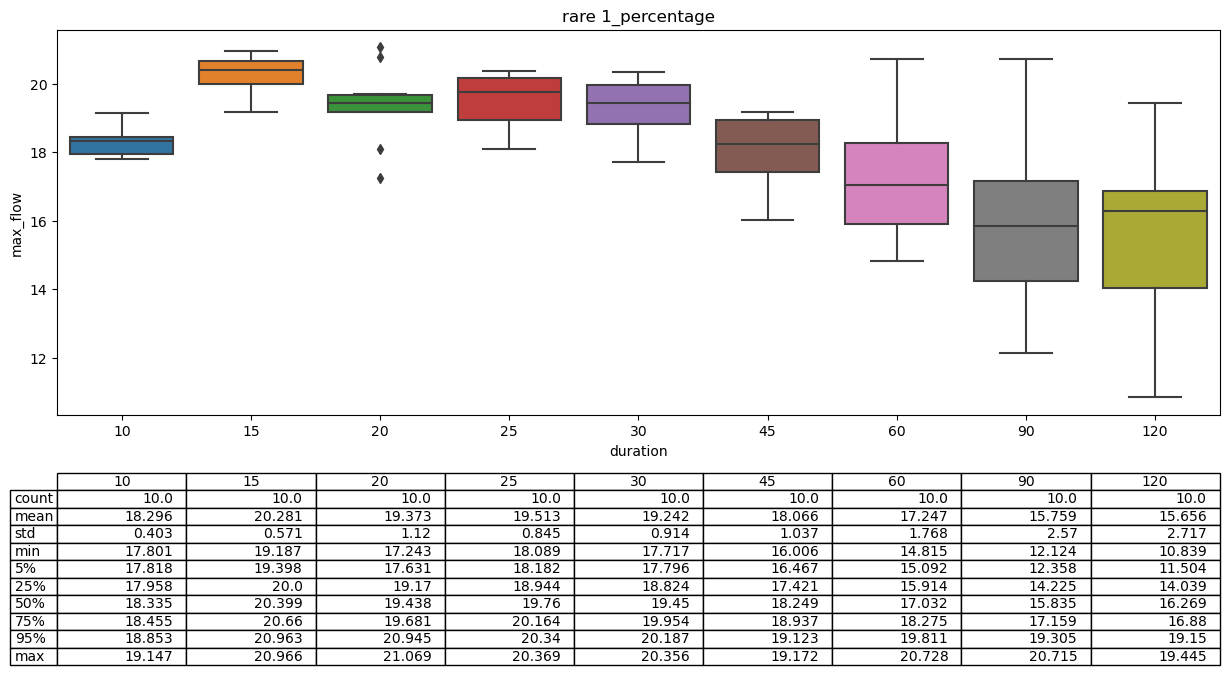

In [13]:
for index_3 in titles.index:
    c1 = max_flow_list[(max_flow_list.frequency == titles.frequency[index_3]) & (max_flow_list.freq_AEP == titles.freq_AEP[index_3])]
    c2 = statistics.loc[titles.frequency[index_3], titles.freq_AEP[index_3]].T
    c3 = plt.figure(figsize=(15,5))
    c4 = sns.boxplot(data=c1,
                     x='duration',
                     y='max_flow',
                     )
    c4.set(title='{} {}'.format(titles.frequency[index_3], titles.freq_AEP[index_3][7:]))
    c5 = plt.table(cellText=c2.to_numpy().round(decimals=3),
                   rowLabels=list(ind[1] for ind in c2.index),
                   colLabels=list(c2.columns),
                   bbox=[0, -0.65, 1, 0.5],
                   )
    c5.auto_set_font_size(False)
    c5.set_fontsize(10)
    c6 = plt.savefig('../GSPSWMMH__{}__{}.png'.format(titles.frequency[index_3], titles.freq_AEP[index_3][7:]), bbox_inches='tight')

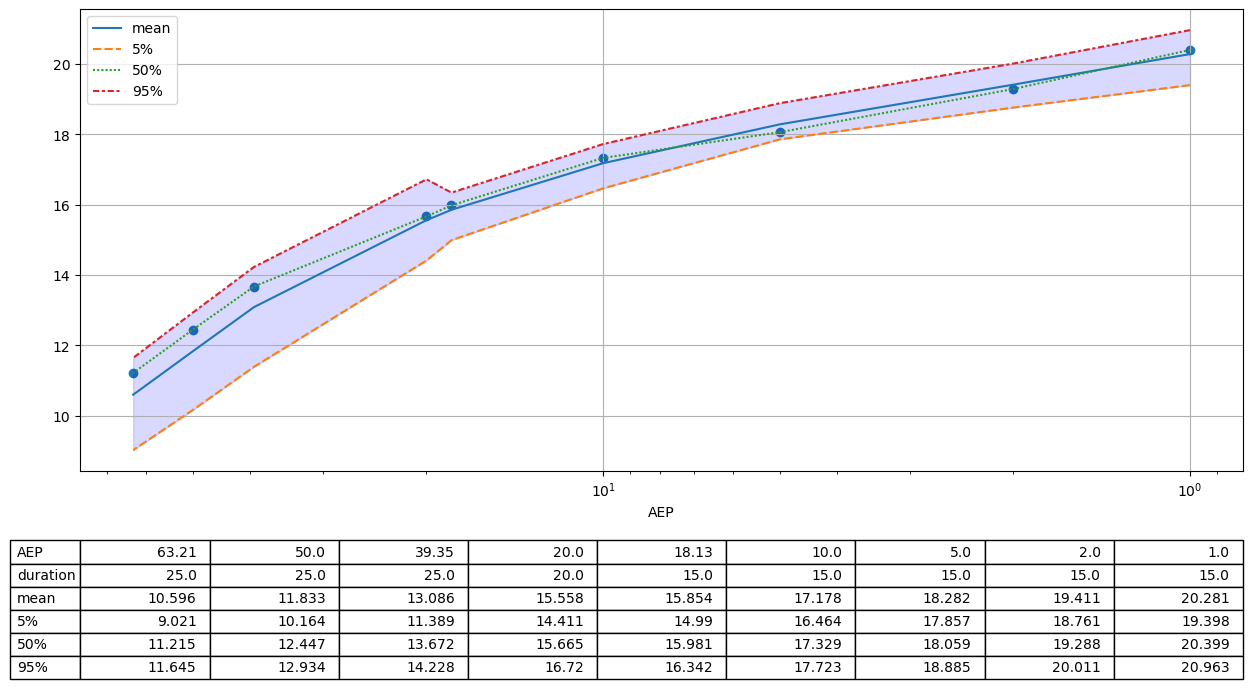

In [12]:
d0 = plt.figure(figsize=(15,6))
d1 = sns.lineplot(data=design_flows[design_flows.columns[3:]].set_index('AEP'))
d1.set(xscale='log')
d1.invert_xaxis()
d1.grid()
d1.scatter(data=design_flows, 
           x='AEP',
           y='50%'
           )
d0 = plt.table(cellText=design_flows[['AEP', 'duration', 'mean', '5%', '50%', '95%']].T.to_numpy().round(decimals=3),
               rowLabels=list(design_flows[['AEP', 'duration', 'mean', '5%', '50%', '95%']].T.index),
               bbox=[0, -0.45, 1, 0.3],
               )
line = d1.get_lines()
d0 = plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[3].get_ydata(), color='blue', alpha=.15)
d2 = plt.savefig('../GSPSWMMH_design_flows.png', bbox_inches='tight')